# An example of using candex with source netCDF files in regular Latitude and Longitude
## Remapping of ERA5 to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
# loading candex
from candex.candex import candex

# initializing candex object
cndx = candex()

# specifying candex objects
# name of the case; the temporary, remapping and remapped file names include case name
cndx.case_name                = 'ERA5_Medicine_Hat'              
# temporary path that the candex generated GIS files and remapped file will be saved
cndx.temp_dir                 = '../temporary/'
# name of target shapefile that the source netcdf files should be remapped to
cndx.sink_shp                 = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
# name of netCDF file(s); multiple files can be specified with *
cndx.source_nc                = '../data/Source_nc_ERA5/ERA5_NA_*.nc'
# name of variables from source netCDF file(s) to be remapped
cndx.var_names                = ['airtemp','pptrate']
# name of variable longitude in source netCDF files
cndx.var_lon                  = 'longitude'
# name of variable latitude in source netCDF files
cndx.var_lat                  = 'latitude'
# name of variable time in source netCDF file; should be always time
cndx.var_time                 = 'time'
# location where the remapped netCDF file will be saved
cndx.output_dir               = '../output/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
cndx.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
cndx.fill_value_list          = ['-9999.00']
# if uncommented candex will use this and skip GIS tasks
#cndx.remap_csv                = '../temporary/ERA5_Medicine_Hat_remapping.csv'

# execute candex
cndx.run_candex()


no  author name is provide and the author name is changes to (author name)!
candex is given multiple varibales to be remapped but only on format and fill valuecandex repeat the format and fill value for all the variables in output files
remap file is provided; candex will use this file and skip calculation of remapping
candex case exists in the remap file
candex detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
candex detects that all the varibales have dimensions of:
['time', 'latitude', 'longitude']
candex detects that the longitude varibales has dimensions of:
['longitude']
candex detects that the latitude varibales has dimensions of:
['latitude']
Remapping ../data/Source_nc_ERA5/ERA5_NA_19790101.nc to ../output/ERA5_Medicine_Hat_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-03-02 14:25:41.230008
Ended   at date and time 2021-03-02 14:25:41.469591
Remapping ../data/Source_nc_ERA5/ERA5_NA_19790102.n

In [2]:
print(cndx.remap_csv)

../temporary/ERA5_Medicine_Hat_remapping.csv


--------------
--------------
# Visualization of the source and the results

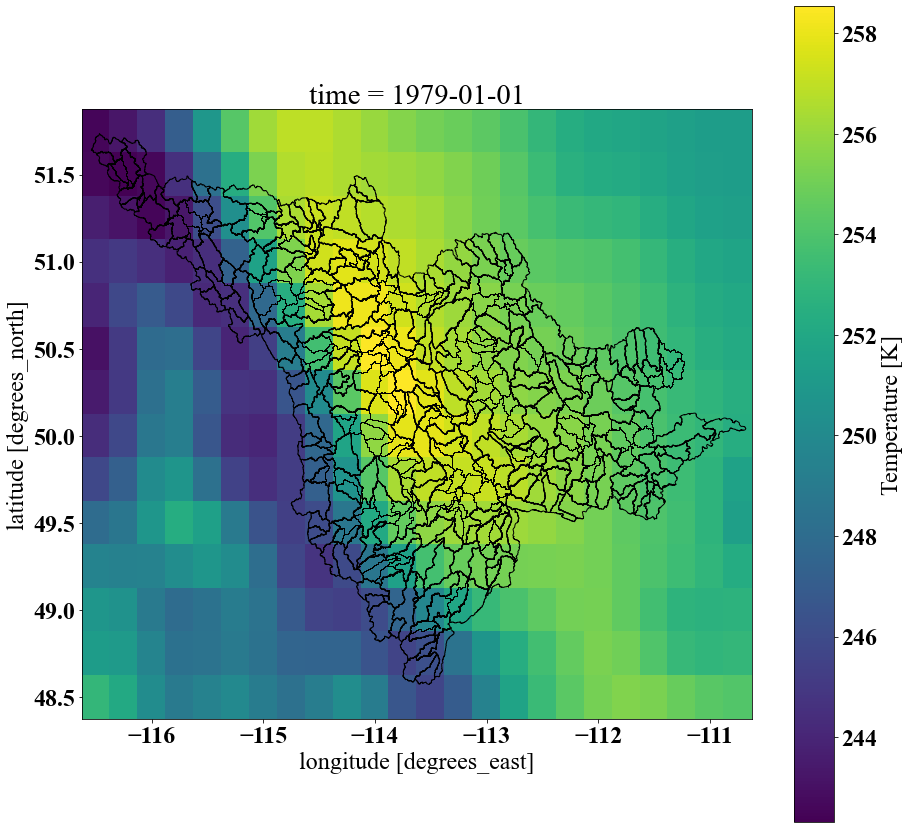

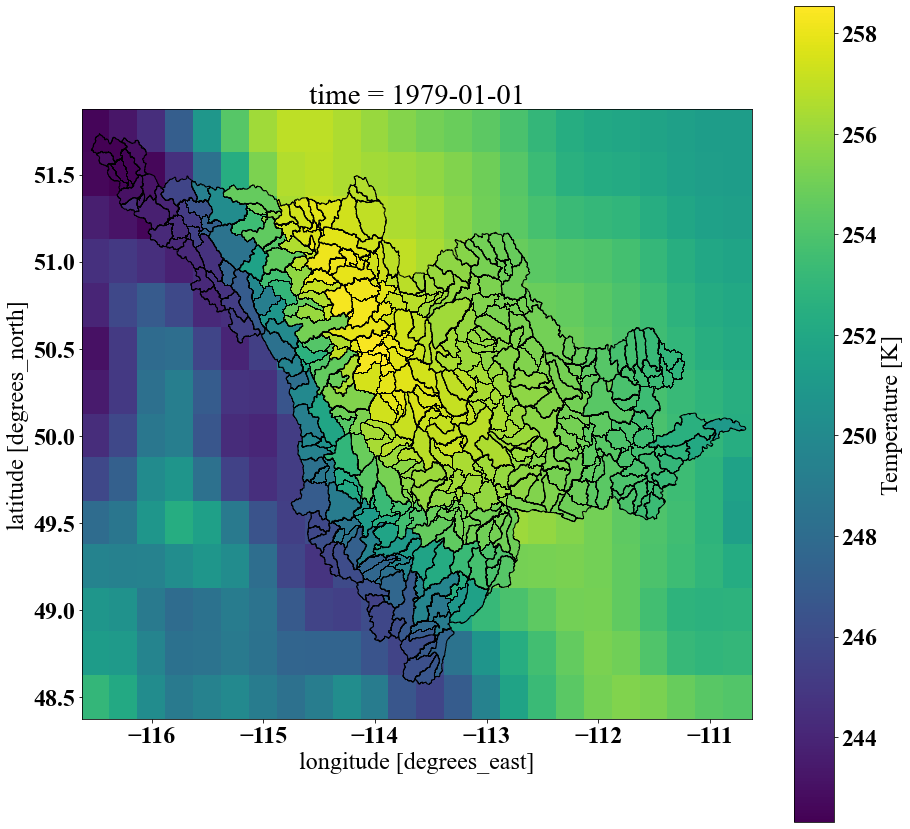

In [2]:
# visualize the result
import geopandas as gpd
import xarray as xr
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)


# visualize the original netCDF for the first file, first time step
shp_target = gpd.read_file(cndx.sink_shp) # load the target shapefile
# load the first source netcdf file
nc_name = sorted(glob.glob(cndx.source_nc))
ds_source = xr.open_dataset(nc_name[0])
# subset the region of interest:
lat_lim = np.array([ 48.2 , 51.7 ]) # limit for lat
lon_lim = np.array([ -116.5 , -110.5 ]) # limit for lon
lats = np.array(ds_source.variables[cndx.var_lat][:] )
lons = np.array(ds_source.variables[cndx.var_lon][:])
lat_low = np.argmin( np.abs( lats - lat_lim[0] ) )
lat_up = np.argmin( np.abs( lats - lat_lim[1] ) )
lon_low = np.argmin( np.abs( lons - lon_lim[0] ) )
lon_up = np.argmin( np.abs( lons - lon_lim[1] ) )
if lat_up < lat_low:
    temp = lat_low
    lat_low = lat_up
    lat_up = temp
if lon_up < lon_low:
    temp = lon_low
    lon_low = lon_up
    lon_up = temp
ds_source = ds_source.isel(latitude=np.arange(lat_low,lat_up))
ds_source = ds_source.isel(longitude=np.arange(lon_low,lon_up))
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
ds_source.airtemp[0,:,:].plot( ax = axes)
shp_target.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1, ax = axes)
plt.savefig('../fig/Example1_A.png')


# visualize the remapped netCDF for the first file, first time step
# target nc file
nc_names = sorted(glob.glob (cndx.output_dir + cndx.case_name + '*.nc'))
ds       = xr.open_dataset(nc_names[0]) # the first netcdf file
values   = ds.airtemp [0,:] # the first time frame of the first 
IDs      = ds.ID [:] # get the ID
# create a data frame for the model simulation
df = pd.DataFrame()
df ['value'] = values
df ['ID_t']    = IDs  # .astype(int)
df = df.sort_values (by = 'ID_t')
# load the shape file target that is generated by candex (with consistent IDs)
shp_target = gpd.read_file(cndx.temp_dir+ cndx.case_name + '_sink_shapefile.shp') # load the target shapefile
shp_target ['ID_t'] = shp_target ['ID_t'].astype(float)
shp_target = shp_target.sort_values(by='ID_t')# sort on values
shp_target = pd.merge_asof(shp_target, df, on='ID_t', direction='nearest')
shp_target = shp_target.set_geometry('geometry') #bring back the geometry filed; pd to gpd
# plotting
f, axes = plt.subplots(1,1,figsize=(15,15))
ds_source.airtemp[0,:,:].plot( ax = axes)
ds_source.airtemp[0,:,:].plot( ax = axes, alpha = 1, add_colorbar=False)
shp_target.plot(column= 'value', edgecolor='k',linewidth = 1, ax = axes )#, legend=True)
plt.savefig('../fig/Example1_B.png')

